In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
import seaborn as sns

In [2]:
# 삼성전자, 2017년 ~ 현재 일별 시세 받아오기
df_samsung = fdr.DataReader('005930')
df_samsung.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,19721.179333,19940.290167,19502.557167,19748.340333,2.340448e+06,0.001056
std,16993.641591,17170.281783,16825.857609,17005.261919,6.069328e+06,0.025826
min,0.000000,0.000000,0.000000,627.000000,0.000000e+00,-0.137566
25%,7047.500000,7179.750000,6950.000000,7060.000000,2.692385e+05,-0.012342
50%,13169.500000,13260.000000,13020.000000,13160.000000,4.391780e+05,0.000000
75%,27345.000000,27580.000000,27120.000000,27360.000000,7.894305e+05,0.013092
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


In [3]:
# 삼성전자 데이터 전처리
df_samsung_ri = df_samsung.rename_axis('Date').reset_index() # Date 인덱스를 컬럼으로 
df_samsung_ri

,Date,Open,High,Low,Close,Volume,Change
0,1997-03-26,1077,1093,1052,1067,298387,NaN
1,1997-03-27,1058,1067,1031,1032,148690,-0.032802
2,1997-03-28,1031,1058,1024,1039,176870,0.006783
3,1997-03-29,1038,1077,1020,1053,88160,0.013474
4,1997-03-31,1061,1065,1028,1065,161770,0.011396
...,...,...,...,...,...,...,...
5995,2021-03-11,81000,82500,81000,82000,23818297,0.013597
5996,2021-03-12,83100,83500,82400,82800,13530573,0.009756
5997,2021-03-15,82800,82900,81800,81800,13735798,-0.012077
5998,2021-03-16,82200,83000,82100,82800,12293537,0.012225


In [5]:
# 날짜 datetime 포맷으로 변환
df_samsung_ri['Date'] = pd.to_datetime(df_samsung_ri['Date'], format='%Y%m%d')
df_samsung_ri['year'] = df_samsung_ri['Date'].dt.year
df_samsung_ri['month'] = df_samsung_ri['Date'].dt.month
df_samsung_ri['day'] = df_samsung_ri['Date'].dt.day

Text(0, 0.5, 'price')

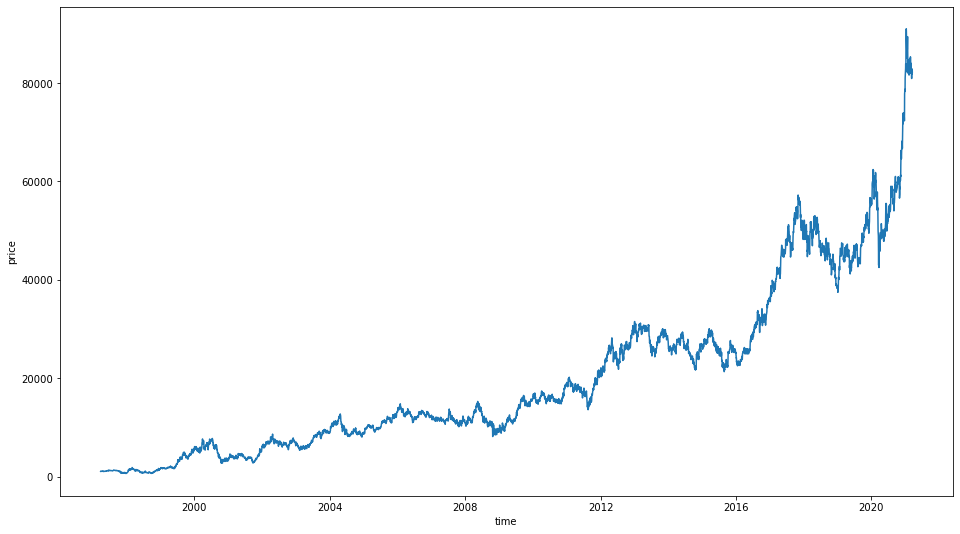

In [6]:
#1990 년도 이후의 주가 시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=df_samsung_ri['Close'], x=df_samsung_ri['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [7]:
# 결측치 제거
df_samsung_ri= df_samsung_ri.dropna() # 결측치 제거
df_samsung_ri.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
year      0
month     0
day       0
dtype: int64

In [9]:
# 정규화 sklearn 패키지의 MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#스케일을 적용할 컬럼 정의
scale_cols = ['Open','High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_samsung_ri[scale_cols])
df_scaled
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

In [12]:
#학습 데이터 셋 생성
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(df_samsung_ri.drop('Close', 1), df_samsung_ri['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(df_samsung_ri.drop('Close', 1), df_samsung_ri['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train

In [13]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [14]:
TEST_SIZE = 200

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]


In [15]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))